# Constructing Databases for MCA, EOCR, and EOCL
---
30-second time windows centered around envelope peak at 5-10 Hz, store 1-10 Hz signal

In [1]:
%%time
import glob, datetime, warnings, utm, mcaap, sys, random, pickle
sys.path.append('/Users/mronacgiannone/Documents/Cardinal')
import cardinal
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from obspy import *
from obspy.core import *
from scipy import signal
from pyproj import Geod; g = Geod(ellps='sphere')
from scipy.signal import hilbert
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings('ignore')

# Global variables where data are stored
winter_data_dir = '/Volumes/Extreme SSD/McAAP/Winter_2021/'

# Freq ranges (Averbuch et al. [2022])
freqmin=1; freqmax=10

CPU times: user 5.75 s, sys: 5.18 s, total: 10.9 s
Wall time: 21.4 s


---
Ancillary functions

In [2]:
def pad_to_target_time(x, T, axis=-1, mode='edge', *, noise_scale=1.0, robust=False, seed=None):
    """
    Pad/trim along `axis` to length T.

    mode:
      - 'edge'    : repeat the last sample
      - 'reflect' : mirror the tail (skip endpoint)
      - 'noisy'   : pad with PURE zero-mean noise ~ N(0, σ^2),
                    σ from the window per series (or MAD-based if robust=True)
    """
    x = np.asarray(x)
    if not np.issubdtype(x.dtype, np.floating):
        x = x.astype(np.float32)

    x_move = np.moveaxis(x, axis, -1)  # (..., N)
    N = x_move.shape[-1]

    if N == T:
        return x
    if N == 0:
        raise ValueError("Cannot pad from an empty axis.")
    if N > T:
        y = x_move[..., :T]
        return np.moveaxis(y, -1, axis)

    pad = T - N

    if mode == 'edge':
        last = x_move[..., -1:]                     # (..., 1)
        pad_block = np.repeat(last, pad, axis=-1)   # (..., pad)

    elif mode == 'reflect':
        tail = np.flip(x_move[..., :-1], axis=-1)   # (..., N-1)
        if tail.shape[-1] == 0:                     # N==1 -> fallback
            last = x_move[..., -1:]
            pad_block = np.repeat(last, pad, axis=-1)
        else:
            reps = int(np.ceil(pad / tail.shape[-1]))
            pad_block = np.concatenate([tail] * reps, axis=-1)[..., :pad]

    elif mode == 'noisy':
        # PURE noise centered at 0
        if robust:
            med = np.median(x_move, axis=-1, keepdims=True)
            mad = np.median(np.abs(x_move - med), axis=-1, keepdims=True)
            sigma = 1.4826 * mad
        else:
            sigma = x_move.std(axis=-1, keepdims=True)
        sigma = noise_scale * sigma

        rng = np.random.default_rng(seed)
        pad_block = rng.normal(0.0, 1.0, size=x_move[..., :pad].shape).astype(x_move.dtype) * sigma

    else:
        raise ValueError("mode must be 'edge', 'reflect', or 'noisy'")

    y = np.concatenate([x_move, pad_block], axis=-1)
    return np.moveaxis(y, -1, axis)

def center_by_env_peak(data):
    """
    Center via the peak of the analytic-signal envelope (no smoothing).
    - data: 1D numpy array
    """
    x = np.asarray(data, dtype=np.float32)
    x = x/np.max(np.abs(x))
    analytic_signal = signal.hilbert(x)
    env = np.abs(analytic_signal)
    i = int(np.argmax(env))
    i_hat = float(i)
    k_shift = (len(x) / 2.0) - i_hat   # no clamp
    return k_shift

def shift_extrapolate_time(x, shift, axis=-1, mode='edge', *, noise_scale=1.0, robust=False, seed=None):
    """
    Shift along `axis` by `shift` samples with interpolation.

    Modes
    -----
    'edge'        : clamp to first/last sample
    'reflect'     : symmetric reflection
    'extrapolate' : linear extrapolation from first/last two samples
    'noisy'       : OUT-OF-BOUNDS -> pure zero-mean noise ~ N(0, σ^2),
                    σ from the window per series (or MAD-based if robust=True).
                    IN-BOUNDS -> regular linear interpolation.
    """
    x = np.asarray(x)
    if not np.issubdtype(x.dtype, np.floating):
        x = x.astype(np.float32)

    x_move = np.moveaxis(x, axis, -1)  # (..., T)
    T = x_move.shape[-1]
    s = float(shift)

    t = np.arange(T, dtype=np.float64)  # output indices
    u = t - s                           # where to sample from input

    flat = x_move.reshape(-1, T)        # (N, T)
    N = flat.shape[0]

    if T == 0:
        return x.copy()

    # Common interpolation for interior (used by edge/reflect/noisy)
    def interp_at(u_vals):
        u_clamped = np.clip(u_vals, 0.0, T - 1.0)
        u0 = np.floor(u_clamped).astype(np.int64)
        u1 = np.minimum(u0 + 1, T - 1)
        alpha = (u_clamped - u0).astype(flat.dtype)
        return (1.0 - alpha) * flat[:, u0] + alpha * flat[:, u1]

    if mode == 'edge':
        y_flat = interp_at(np.clip(u, 0.0, T - 1.0))

    elif mode == 'reflect':
        if T > 1:
            period = 2.0 * (T - 1.0)
            u_ref = np.mod(u, period)
            u_ref = np.where(u_ref <= (T - 1.0), u_ref, period - u_ref)
        else:
            u_ref = np.zeros_like(u)
        y_flat = interp_at(u_ref)

    elif mode == 'extrapolate':
        y_flat = np.empty((N, T), dtype=flat.dtype)
        if T == 1:
            y_flat[:] = flat[:, [0]]
        else:
            u_b = u[None, :]
            s0 = (flat[:, 1] - flat[:, 0])[:, None]
            sN = (flat[:, -1] - flat[:, -2])[:, None]

            idxL = np.where(u < 0.0)[0]
            idxR = np.where(u > (T - 1.0))[0]
            idxI = np.where((u >= 0.0) & (u <= (T - 1.0)))[0]

            if idxL.size:
                y_flat[:, idxL] = flat[:, 0:1] + u_b[:, idxL] * s0
            if idxR.size:
                y_flat[:, idxR] = flat[:, -1:] + (u_b[:, idxR] - (T - 1.0)) * sN
            if idxI.size:
                uI = u[idxI]
                u0I = np.clip(np.floor(uI).astype(np.int64), 0, T - 2)
                u1I = u0I + 1
                alphaI = (uI - u0I).astype(flat.dtype)
                y_flat[:, idxI] = (1.0 - alphaI) * flat[:, u0I] + alphaI * flat[:, u1I]

    elif mode == 'noisy':
        # Interior = interpolation; tails = pure zero-mean noise
        y_flat = interp_at(u)  # start with interior everywhere, overwrite tails

        rng = np.random.default_rng(seed)
        if robust:
            med = np.median(flat, axis=1, keepdims=True)
            mad = np.median(np.abs(flat - med), axis=1, keepdims=True)
            sigma = 1.4826 * mad
        else:
            sigma = flat.std(axis=1, keepdims=True)

        sigma *= noise_scale

        idxL = np.where(u < 0.0)[0]
        idxR = np.where(u > (T - 1.0))[0]

        if idxL.size:
            noiseL = rng.normal(0.0, 1.0, size=(N, idxL.size)).astype(flat.dtype) * sigma
            y_flat[:, idxL] = noiseL  # baseline = 0
        if idxR.size:
            noiseR = rng.normal(0.0, 1.0, size=(N, idxR.size)).astype(flat.dtype) * sigma
            y_flat[:, idxR] = noiseR  # baseline = 0
    else:
        raise ValueError("mode must be 'edge', 'reflect', 'extrapolate', or 'noisy'")

    y = y_flat.reshape(x_move.shape)
    return np.moveaxis(y, -1, axis)

from scipy.signal import butter, filtfilt

def _butter_band(fs, f_lo, f_hi, order=4):
    nyq = 0.5 * fs
    lo = max(f_lo / nyq, 1e-6)
    hi = min(f_hi / nyq, 1.0 - 1e-6)
    if not (0 < lo < hi < 1):
        raise ValueError("Band edges out of range.")
    return butter(order, [lo, hi], btype='band')

def measure_band_snr_db_waveform(x, fs, f_lo=5.0, f_hi=10.0, order=4, eps=1e-12):
    x = np.asarray(x)
    b, a = _butter_band(fs, f_lo, f_hi, order)
    xb = filtfilt(b, a, x, axis=-1)         # in-band "signal"
    P_sig = np.mean(xb**2, axis=-1)
    P_tot = np.mean(x**2,  axis=-1)
    P_off = np.maximum(P_tot - P_sig, 0.0) + eps
    return 10.0 * np.log10((P_sig + eps) / P_off)

def add_lowband_noise_to_hit_snr_db(x, fs, target_snr_db, axis=-1, order=4, guard_hz=0.3, relax=0.8, seed=None):
    """
    Add *off-band* noise (≈1–5 Hz) so SNR_dB = 10*log10(P_5-10 / (P_total - P_5-10))
    matches target_snr_db. Leaves 5–10 Hz morphology untouched.
    """
    x = np.asarray(x)
    xT = np.moveaxis(x, axis, -1)  # (..., T)

    # Current in-band (5–10) and off-band (1–5) powers
    b_hi, a_hi = _butter_band(fs, 5.0, 10.0, order)
    b_lo, a_lo = _butter_band(fs, 1.0,  5.0,  order)
    x_hi = filtfilt(b_hi, a_hi, xT, axis=-1); P_hi = np.mean(x_hi**2, axis=-1, keepdims=True)
    x_lo = filtfilt(b_lo, a_lo, xT, axis=-1); P_lo = np.mean(x_lo**2, axis=-1, keepdims=True)

    # Desired off-band power to hit target SNR
    target_lin = 10.0 ** (target_snr_db / 10.0)
    P_lo_target = P_hi / np.maximum(target_lin, 1e-8)
    delta = P_lo_target - P_lo
    # If already noisy enough (delta <= 0), return unchanged
    if np.all(delta <= 0):
        return x

    # Build low-band noise template in 1 – (5 - guard)
    f_hi_noise = max(5.0 - guard_hz, 1.5)
    bN, aN = _butter_band(fs, 1.0, f_hi_noise, order)
    rng = np.random.default_rng() if seed is None else np.random.default_rng(seed)
    w = rng.normal(0.0, 1.0, size=xT.shape).astype(xT.dtype)
    n = filtfilt(bN, aN, w, axis=-1)

    # Compute off-band power of the template to scale it
    n_lo = filtfilt(b_lo, a_lo, n, axis=-1)
    c = np.mean(n_lo**2, axis=-1, keepdims=True) + 1e-12

    sigma = np.sqrt(np.maximum(delta, 0.0) / c) * float(relax)  # relax < 1 softens
    x_noisy = xT + sigma * n
    return np.moveaxis(x_noisy, -1, axis)

---
Construct MCA Dataset

In [3]:
%%time
# Directory path to MCA trimmed data
file_pattern = winter_data_dir+'MCA_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
MCA_data = []; row_labels_MCA = []
for MCA_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(MCA_data_filepath); st = st.resample(40).merge() # need to resample to keep all input feature vectors the same length
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter 5 - 10 Hz center cue and store 1 - 10 Hz
    st_center = st.copy() # 5 - 10 Hz center cue
    st_center.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_center.filter('bandpass', freqmin=5, freqmax=10)
    except:
        st_center = st_center.split()
        st_center.filter('bandpass', freqmin=5, freqmax=10)
        st_center.merge()
    # Filter 1 - 10 Hz store
    st_save = st.copy()
    st_save.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_save.filter('bandpass', freqmin=1, freqmax=10)
    except:
        st_save = st_save.split()
        st_save.filter('bandpass', freqmin=1, freqmax=10)
        st_save.merge()
    julian_day = MCA_data_filepath[-8:-6] # as string
    for tr in st_center:
        # Load onset times for each station
        signal_onset_time_filepath = winter_data_dir+'MCA_Detections/Signal_Times_CWT/'+tr.stats.station+'_'+tr.stats.channel+'/'+julian_day+'.npy'
        with open(signal_onset_time_filepath, 'rb') as f: # loading signal onset times
            MCA_times_tmp = np.load(f)[0]
        #-----------------------------------------------------------------------------------------------------------------------#
        # Extract data from each trace using 30 second windows (+/- 15 seconds from signal onset time)
        t = np.arange(0, tr.stats.delta*tr.stats.npts, tr.stats.delta)
        # match same station in st_save
        tr_s_list = st_save.select(station=tr.stats.station)
        if len(tr_s_list) == 0: 
            continue
        tr_s = tr_s_list[0]
        # Window +/-15 s around beam onset (same cut for both)
        st_tmp = Stream().append(tr)
        st_tmp_s = Stream().append(tr_s)   
        for sig_idx in range(len(MCA_times_tmp)):
            #-----------------------------------------------------------------------------------------------------------------------#
            # Need to rename stations for MCA
            if tr.stats.channel == 'BDF': label_tmp = 'MCA01'
            elif tr.stats.channel == 'HHZ': label_tmp = 'MCA02'
            elif tr.stats.channel == 'HHE': label_tmp = 'MCA03'
            elif tr.stats.channel == 'HHN': label_tmp = 'MCA04'
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number
            row_labels_MCA_tmp = f"{str(tr.stats.starttime).split('T')[0]}_{label_tmp}_{sig_idx+1}"
            row_labels_MCA.append(row_labels_MCA_tmp)
            #-----------------------------------------------------------------------------------------------------------------------#
            # Retrieve time windowed data
            t_data, data = cardinal.data_time_window(t, st_tmp, t_start=MCA_times_tmp[sig_idx]-15, t_end=MCA_times_tmp[sig_idx]+15)
            _, data_s = cardinal.data_time_window(t, st_tmp_s, t_start=MCA_times_tmp[sig_idx]-15, t_end=MCA_times_tmp[sig_idx]+15)        
            #-----------------------------------------------------------------------------------------------------------------------# 
            # Enforce target length (time axis is axis=1) - just in case
            fs = float(tr.stats.sampling_rate)
            target_length = int(30 * fs) # e.g., 40 s @ fs 
            data = pad_to_target_time(data, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            data_s = pad_to_target_time(data_s, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            #-----------------------------------------------------------------------------------------------------------------------#
            # Compute shift from 5–10 Hz window, apply to 1–10 Hz window
            x = data[0, :].astype(np.float32)  # (T,)
            k_shift = center_by_env_peak(x) # time shift to center
            x_s = data_s[0, :].astype(np.float32)
            x_s_centered = shift_extrapolate_time(x_s[None,:], k_shift, axis=1, mode='noisy', noise_scale=0.1)[0]   
            #-----------------------------------------------------------------------------------------------------------------------#
            # Lower direct SNR in 1-5 Hz band to match strat cross-spectral SNR
            rng = np.random.default_rng(123)
            # Use your strat stats (dB):
            mu, sigma = -3.50, 4.47 # mu is median
            p10, p90  = -10, 1.10
            target = float(np.clip(rng.normal(mu, sigma), p10, p90))
            # After you create x_s_centered (your 1–10 Hz window):
            x_bal = add_lowband_noise_to_hit_snr_db(x_s_centered, fs, target_snr_db=target, order=4, guard_hz=0, relax=0.5, seed=None)
            MCA_data.append(x_bal)
MCA_data = np.array(MCA_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_MCA = {label: MCA_data[idx] for idx, label in enumerate(row_labels_MCA)}
print(MCA_data.shape)

(2345, 1200)
CPU times: user 36.1 s, sys: 517 ms, total: 36.6 s
Wall time: 37.8 s


<IPython.core.display.Javascript object>


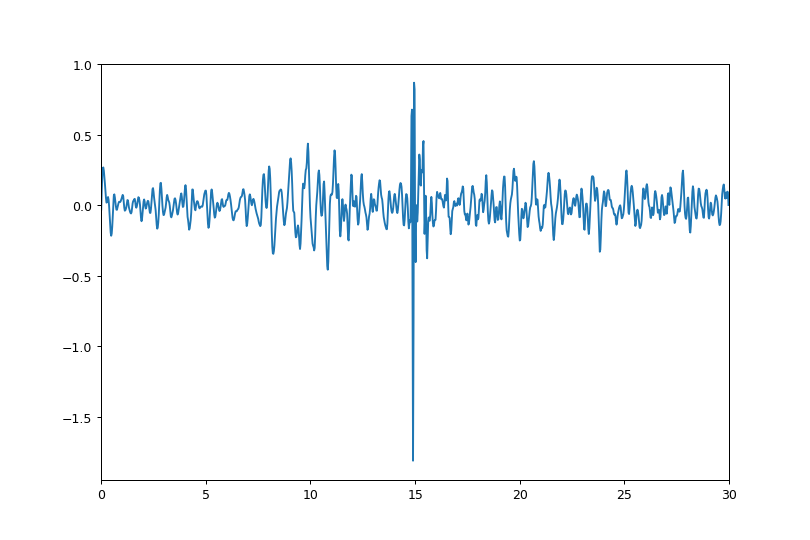

(0.0, 30.0)

In [4]:
%matplotlib notebook
# Generate a random integer between 0 and total number of signals at MCA
rand_int = random.randint(0, MCA_data.shape[0])
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting randomly indexed signal
fig = plt.figure(figsize=(9,6))
data_tmp = mcaap.extract_signals_from_dict(row_dict_MCA, rand_int)[1]
plt.plot(t_data, data_tmp)
plt.xlim([0,30])

---
Construct EOCR Dataset

In [5]:
%%time
# Directory path to EOCR trimmed data
file_pattern = winter_data_dir+'EOCR_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
EOCR_data = []; row_labels_EOCR = []
for EOCR_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(EOCR_data_filepath)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter 5 - 10 Hz center cue and store 1 - 10 Hz
    st_center = st.copy() # 5 - 10 Hz center cue
    st_center.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_center.filter('bandpass', freqmin=5, freqmax=10)
    except:
        st_center = st_center.split()
        st_center.filter('bandpass', freqmin=5, freqmax=10)
        st_center.merge()
    # Filter 1 - 10 Hz store
    st_save = st.copy()
    st_save.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_save.filter('bandpass', freqmin=1, freqmax=10)
    except:
        st_save = st_save.split()
        st_save.filter('bandpass', freqmin=1, freqmax=10)
        st_save.merge()
    julian_day = EOCR_data_filepath[-8:-6] # as string
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load start and end times for all signals on this day
    df_tmp = pd.read_csv(winter_data_dir+'EOCR_Detections/Signal_Times/'+julian_day+'.csv')
    for tr in st_center:
        #-----------------------------------------------------------------------------------------------------------------------#
        # Extract data from each trace using 30 second windows (+/- 15 seconds from signal onset time)
        t = np.arange(0, tr.stats.delta*tr.stats.npts, tr.stats.delta)
        # match same station in st_save
        tr_s_list = st_save.select(station=tr.stats.station)
        if len(tr_s_list) == 0: 
            continue
        tr_s = tr_s_list[0]
        # Window +/-15 s around beam onset (same cut for both)
        st_tmp = Stream().append(tr)
        st_tmp_s = Stream().append(tr_s)       
        for sig_idx in range(len(df_tmp)): # loop through each signal
            #-----------------------------------------------------------------------------------------------------------------------#
            # Retrieve signal time from Cardinal families detections
            sig_time_tmp = (df_tmp['end_time'][sig_idx] + df_tmp['start_time'][sig_idx]) / 2 # use midpoint between Cardinal families' start and end times
            #-----------------------------------------------------------------------------------------------------------------------#
            # Manually shifting and/or removing signals based on plots (minus means shift to right, plus means shift to left)
            k = 0
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-13') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 2): # need to provide date, sensor, and signal #
                k -= 7 # right
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-13') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 3):
                k += 12 # left
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-13') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 4):
                k -= 6
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-20') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 9):
                k += 2
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-20') and (sig_idx+1 == 49):
                continue # remove
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 2):
                continue 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 2):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 6):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 7):
                k += 12 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 8):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 12):
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 15):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 16):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 17):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 17):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 17):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 18):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 19):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 20):
                k += 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 1):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 2):
                k -= 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 3):
                k += 5       
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 4):
                k -= 4
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 4):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 15):
                k -= 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 15):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 16):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 21):
                k += 2
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 23):
                k += 15
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 23):
                k += 15
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 23):
                k += 15
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 23):
                k += 15
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 25):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 26):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 27):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 27):
                k += 2
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 27):
                k += 12
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 28):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 28):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 28):
                k -= 4
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 28):
                k += 5       
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 28):
                k += 5  
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 29):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 29):
                k -= 7             
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 29):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 29):
                k += 5   
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 29):
                k += 5      
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 30):
                continue                   
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 30):
                continue                    
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 30):
                k += 2      
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 30):
                k += 2     
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 31):
                k += 5  
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 31):
                continue                  
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 32):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 32):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 32):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 33):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 33):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 33):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 33):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 34):
                k += 5  
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 35):
                k += 5  
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 36):
                k += 5  
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 37):
                k += 5 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 38):
                k += 5 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 39):
                k += 5 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 40):
                k += 5 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 41):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 41):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 41):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 42):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 43):
                k += 5      
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 44):
                k += 5 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 45):
                k += 5 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 45):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 46):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 46):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 46):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 46):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 46):
                k += 16
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 47):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 47):
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 47):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 47):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 48):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 48):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 48):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 49):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 49):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 49):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 49):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 50):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 50):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 50):
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 1):
                k -= 9
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 1):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 1):
                k -= 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 1):
                k -= 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 2):
                k -= 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 2):
                k -= 13
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 3):
                k -= 13
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 4):
                k += 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 8):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 14):
                k += 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 19):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 20):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 21):
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 21):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 21):
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 26):
                k += 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 28):
                k -= 12               
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 29):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 29):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 29):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 29):
                k += 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 30):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 32): 
                k -= 12 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 33): 
                k += 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 35):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 36):
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 43):
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (sig_idx+1 == 46):
                k += 3
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (sig_idx+1 == 47):
                k += 5                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 50): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 50): 
                k += 2
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 50): 
                k += 5                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 50): 
                k += 5 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 50): 
                k += 2
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-28') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 7): 
                k += 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-28') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 32): 
                k += 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 1): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 2): 
                k -= 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 2): 
                k -= 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (sig_idx+1 == 3): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (sig_idx+1 == 4): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 5): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 5): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 5): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 6): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 11): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 11): 
                k -= 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 12): 
                k -= 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 12): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 13): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 13): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 14): 
                k -= 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 16): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 16): 
                continue                 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 21): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 21): 
                k += 6
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 22): 
                k -= 12
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 22): 
                k += 12
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 23): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 23): 
                k -= 13                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 24): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 26): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 30): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 32): 
                k -= 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 32): 
                k -= 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 33): 
                k -= 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 33): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 34): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 36): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 37): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 37): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 38): 
                k -= 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 38): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 38): 
                k -= 11
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 40): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 41): 
                k += 12
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 42): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-29') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 44): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 1): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 1): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 3): 
                continue                   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 4): 
                k += 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 5): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 5): 
                k -= 12
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 5): 
                k += 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 6): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-01') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 6): 
                k += 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-03') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 1): 
                k += 10
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-03') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 1): 
                k -= 15                
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-03') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 2): 
                k -= 7
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-03') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 2): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-03') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 2): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-03') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 8): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 1): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 1): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 1): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 5): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 5): 
                k += 12
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 6): 
                k -= 12
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 15): 
                k -= 3
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 16): 
                k -= 12 
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-23') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 16): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 2): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 7): 
                k += 3                   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 7): 
                k += 3      
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 8): 
                k += 5                
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 8): 
                k += 5                    
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 8): 
                k += 5       
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 11): 
                k += 5  
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 11): 
                k += 5                
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 11): 
                k += 5                    
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 11): 
                k += 5                   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 12): 
                k += 5  
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 12): 
                k += 5                
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 12): 
                k += 5                    
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC05') and (sig_idx+1 == 12): 
                k += 5     
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 13): 
                k += 5                  
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 16): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 19): 
                k += 5                
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 19): 
                k += 5      
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 20): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC01') and (sig_idx+1 == 25): 
                k += 5   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 25): 
                k += 5   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 25): 
                k += 5   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC04') and (sig_idx+1 == 25): 
                k += 5   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 26): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 27): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 28): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 29): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 30): 
                k += 5
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 30): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 30): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 31): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 32): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 33): 
                continue                   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 36): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 45): 
                k -= 12
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station == 'EOC02') and (sig_idx+1 == 6): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 6): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 7): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 8): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 9): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 11): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 12): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station == 'EOC03') and (sig_idx+1 == 14): 
                continue
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number - helps remove signals
            row_labels_EOCR_tmp = str(tr.stats.starttime).split('T')[0] + '_'+tr.stats.station+'_'+str(sig_idx+1)
            row_labels_EOCR.append(row_labels_EOCR_tmp)
            #-----------------------------------------------------------------------------------------------------------------------#
            # Retrieve time windowed data
            t_data, data = cardinal.data_time_window(t, st_tmp, t_start=sig_time_tmp-15, t_end=sig_time_tmp+15)
            _, data_s = cardinal.data_time_window(t, st_tmp_s, t_start=sig_time_tmp-15, t_end=sig_time_tmp+15)
            #-----------------------------------------------------------------------------------------------------------------------# 
            # Enforce target length (time axis is axis=1) - just in case
            fs = float(tr.stats.sampling_rate)
            target_length = int(30 * fs) # e.g., 40 s @ fs 
            data = pad_to_target_time(data, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            data_s = pad_to_target_time(data_s, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            #-----------------------------------------------------------------------------------------------------------------------#
            # Compute shift from 5–10 Hz window, apply to 1–10 Hz window
            x = data[0, :].astype(np.float32)  # (T,)
            k_shift = center_by_env_peak(x) # time shift to center
            x_s = data_s[0, :].astype(np.float32)
            k_shift += int(round( (-k) * fs))
            x_s_centered = shift_extrapolate_time(x_s[None,:], k_shift, axis=1, mode='noisy', noise_scale=0.1)[0] 
            #-----------------------------------------------------------------------------------------------------------------------#
            # Lower trop SNR in 1-5 Hz band to match strat cross-spectral SNR
            rng = np.random.default_rng(123)
            # Use your strat stats (dB):
            mu, sigma = -3.50, 4.47 # mu is median
            p10, p90  = -10, 1.10
            target = float(np.clip(rng.normal(mu, sigma), p10, p90))
            # After you create x_s_centered (your 1–10 Hz window):
            x_trop_bal = add_lowband_noise_to_hit_snr_db(x_s_centered, fs, target_snr_db=target, order=4, guard_hz=0, relax=0.5, seed=None)
            EOCR_data.append(x_trop_bal)            
EOCR_data = np.array(EOCR_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_EOCR = {label: EOCR_data[idx] for idx, label in enumerate(row_labels_EOCR)}
print(EOCR_data.shape)

(2435, 1200)
CPU times: user 27.4 s, sys: 449 ms, total: 27.9 s
Wall time: 28.1 s


<IPython.core.display.Javascript object>


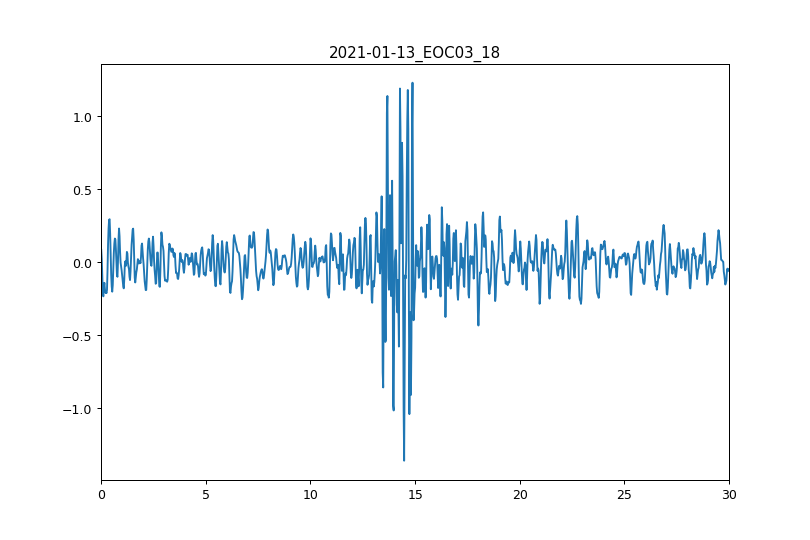

Text(0.5, 1.0, '2021-01-13_EOC03_18')

In [22]:
%matplotlib notebook
# Generate a random integer between 0 and total number of signals at EOCR
rand_int = random.randint(0, EOCR_data.shape[0])
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting randomly indexed signal
fig = plt.figure(figsize=(9,6))
data_label, data_tmp = mcaap.extract_signals_from_dict(row_dict_EOCR, rand_int)
plt.plot(t_data, data_tmp)
plt.xlim([0,30]); plt.title(data_label)

---
Construct EOCL Dataset

In [7]:
%%time
# Directory path to EOCL trimmed data
file_pattern = winter_data_dir+'EOCL_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
EOCL_data = []; row_labels_EOCL = []
for EOCL_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(EOCL_data_filepath)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter 5 - 10 Hz center cue
    st_center = st.copy() # 5 - 10 Hz center cue
    st_center.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_center.filter('bandpass', freqmin=5, freqmax=10)
    except:
        st_center = st_center.split()
        st_center.filter('bandpass', freqmin=5, freqmax=10)
        st_center.merge()
    # Filter 1 - 10 Hz store
    st_save = st.copy()
    st_save.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_save.filter('bandpass', freqmin=1, freqmax=10)
    except:
        st_save = st_save.split()
        st_save.filter('bandpass', freqmin=1, freqmax=10)
        st_save.merge()
    julian_day = EOCL_data_filepath[-8:-6] # as string
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load start and end times for all signals on this day
    df_tmp = pd.read_csv(winter_data_dir+'EOCL_Detections/Signal_Times/'+julian_day+'.csv')
    for tr in st_center:
        #-----------------------------------------------------------------------------------------------------------------------#
        # Extract data from each trace using 30 second windows (+/- 15 seconds from signal onset time)
        t = np.arange(0, tr.stats.delta*tr.stats.npts, tr.stats.delta)
        # match same station in st_save
        tr_s_list = st_save.select(station=tr.stats.station)
        if len(tr_s_list) == 0: 
            continue
        tr_s = tr_s_list[0]
        # Window +/-15 s around beam onset (same cut for both)
        st_tmp = Stream().append(tr)
        st_tmp_s = Stream().append(tr_s)        
        for sig_idx in range(len(df_tmp)): # loop through each signal
            #-----------------------------------------------------------------------------------------------------------------------#
            # Retrieve signal time from Cardinal families detections
            sig_time_tmp = (df_tmp['end_time'][sig_idx] + df_tmp['start_time'][sig_idx]) / 2 # use midpoint between Cardinal families' start and end times
            #-----------------------------------------------------------------------------------------------------------------------#
            # Manually removing signals
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station+tr.stats.location == 'EOCL08') and (sig_idx+1 == 5): # need to provide date, sensor, and signal #
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 5): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station+tr.stats.location == 'EOCL08') and (sig_idx+1 == 15): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station+tr.stats.location == 'EOCL09') and (sig_idx+1 == 15): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-23') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 15): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL09') and (sig_idx+1 == 6): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 6): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL00') and (sig_idx+1 == 11): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 11): 
                continue    
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 14): 
                continue     
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 16): 
                continue 
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL07') and (sig_idx+1 == 19): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL08') and (sig_idx+1 == 19): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL09') and (sig_idx+1 == 19): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 19): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL00') and (sig_idx+1 == 21): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL01') and (sig_idx+1 == 21): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL02') and (sig_idx+1 == 21): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL03') and (sig_idx+1 == 21): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL05') and (sig_idx+1 == 21): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL06') and (sig_idx+1 == 21): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 23): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL00') and (sig_idx+1 == 24): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL05') and (sig_idx+1 == 31): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL06') and (sig_idx+1 == 31): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL07') and (sig_idx+1 == 31): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL08') and (sig_idx+1 == 31): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL09') and (sig_idx+1 == 31): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 31): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 35): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 36): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 39): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 42): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL00') and (sig_idx+1 == 41): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL01') and (sig_idx+1 == 41): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL02') and (sig_idx+1 == 41): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL03') and (sig_idx+1 == 41): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL05') and (sig_idx+1 == 44): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL06') and (sig_idx+1 == 44): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL07') and (sig_idx+1 == 44): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL08') and (sig_idx+1 == 44): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL09') and (sig_idx+1 == 44): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 44): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL00') and (sig_idx+1 == 45): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL01') and (sig_idx+1 == 45): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL02') and (sig_idx+1 == 45): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL03') and (sig_idx+1 == 45): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL06') and (sig_idx+1 == 45): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL08') and (sig_idx+1 == 45): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 45): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 48): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 50): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 52): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 54): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL00') and (sig_idx+1 == 56): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 58): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 60): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 61): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 63): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL00') and (sig_idx+1 == 65): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL01') and (sig_idx+1 == 65): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL02') and (sig_idx+1 == 65): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL03') and (sig_idx+1 == 65): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL05') and (sig_idx+1 == 65): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 65): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 66): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 68): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 70): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL08') and (sig_idx+1 == 72): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (tr.stats.station+tr.stats.location == 'EOCL09') and (sig_idx+1 == 72): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 74): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-26') and (sig_idx+1 == 77): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station+tr.stats.location == 'EOCL07') and (sig_idx+1 == 27): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station+tr.stats.location == 'EOCL08') and (sig_idx+1 == 27): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station+tr.stats.location == 'EOCL09') and (sig_idx+1 == 27): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-27') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 27): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-01-28') and (sig_idx+1 == 25): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 7): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 9): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 11): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 23): 
                continue                   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (tr.stats.station+tr.stats.location == 'EOCL05') and (sig_idx+1 == 26): 
                continue
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 31): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 34): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 38): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-25') and (sig_idx+1 == 53): 
                continue                   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (sig_idx+1 == 3): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (tr.stats.station+tr.stats.location == 'EOCL10') and (sig_idx+1 == 5): 
                continue                
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (sig_idx+1 == 6): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (sig_idx+1 == 10): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (sig_idx+1 == 13): 
                continue   
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (sig_idx+1 == 15): 
                continue  
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (sig_idx+1 == 23): 
                continue 
            if (str(tr.stats.starttime).split('T')[0] == '2021-02-27') and (sig_idx+1 == 28): 
                continue 
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number - helps remove signals
            row_labels_EOCL_tmp = str(tr.stats.starttime).split('T')[0] + '_'+tr.stats.station+tr.stats.location+'_'+str(sig_idx+1)
            row_labels_EOCL.append(row_labels_EOCL_tmp)
            #-----------------------------------------------------------------------------------------------------------------------#
            # Retrieve time windowed data
            t_data, data = cardinal.data_time_window(t, st_tmp, t_start=sig_time_tmp-15, t_end=sig_time_tmp+15)
            _, data_s = cardinal.data_time_window(t, st_tmp_s, t_start=sig_time_tmp-15, t_end=sig_time_tmp+15)                          
            #-----------------------------------------------------------------------------------------------------------------------# 
            # Enforce target length (time axis is axis=1) - just in case
            fs = float(tr.stats.sampling_rate)
            target_length = int(30 * fs) # e.g., 40 s @ fs 
            data = pad_to_target_time(data, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            data_s = pad_to_target_time(data_s, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            #-----------------------------------------------------------------------------------------------------------------------#
            # Compute shift from 5–10 Hz window, apply to 1–10 Hz window
            x = data[0, :].astype(np.float32)  # (T,)
            k_shift = center_by_env_peak(x) # time shift to center
            x_s = data_s[0,:].astype(np.float32)
            x_s_centered = shift_extrapolate_time(x_s[None,:], k_shift, axis=1, mode='noisy', noise_scale=0.1)[0]    
            EOCL_data.append(x_s_centered)            
EOCL_data = np.array(EOCL_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_EOCL = {label: EOCL_data[idx] for idx, label in enumerate(row_labels_EOCL)}
print(EOCL_data.shape)        

(4314, 1200)
CPU times: user 41.9 s, sys: 349 ms, total: 42.3 s
Wall time: 42.6 s


In [8]:
%%time
# Add another code block to time shift and center again? No idea why this works but it does so...whatever
EOCL_data_new = []
for data_idx in range(EOCL_data.shape[0]):
    data_label, data_tmp = mcaap.extract_signals_from_dict(row_dict_EOCL, data_idx)
    # Manually shifting signals based on plots (minus means shift to right, plus means shift to left)
    k = 0
    if data_label == '2021-01-23_EOCL08_15':
        k += 10
    elif data_label == '2021-01-23_EOCL09_15':
        k += 10
    elif data_label == '2021-01-26_EOCL09_6':
        k += 5
    elif data_label == '2021-01-26_EOCL10_6':
        k += 5     
    elif data_label == '2021-01-26_EOCL00_26':
        k -= 15   
    elif data_label == '2021-01-26_EOCL01_26':
        k -= 15 
    elif data_label == '2021-01-26_EOCL02_26':
        k -= 15 
    elif data_label == '2021-01-26_EOCL03_26':
        k -= 15 
    elif data_label == '2021-01-26_EOCL05_26':
        k -= 15 
    elif data_label == '2021-01-26_EOCL06_26':
        k -= 15 
    elif data_label == '2021-01-26_EOCL07_26':
        k -= 15 
    elif data_label == '2021-01-26_EOCL00_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_33':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_34':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_37':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_38':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_38':
        k += 5         
    elif data_label == '2021-01-26_EOCL00_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_40':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_40':
        k += 5      
    elif data_label == '2021-01-26_EOCL00_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_41':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_41':
        k += 5   
    elif data_label == '2021-01-26_EOCL00_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_43':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_43':
        k += 5   
    elif data_label == '2021-01-26_EOCL00_44':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_44':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_44':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_44':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_45':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_45':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_45':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_46':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_46':
        k += 5   
    elif data_label == '2021-01-26_EOCL00_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_47':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_47':
        k += 5   
    elif data_label == '2021-01-26_EOCL00_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_49':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_49':
        k += 5         
    elif data_label == '2021-01-26_EOCL00_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_51':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_53':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_55':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_55':
        k += 5         
    elif data_label == '2021-01-26_EOCL00_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_56':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_57':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_59':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_62':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_62':
        k += 5         
    elif data_label == '2021-01-26_EOCL00_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_64':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_64':
        k += 5   
    elif data_label == '2021-01-26_EOCL06_65':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_65':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_65':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_65':
        k += 5 
    elif data_label == '2021-01-26_EOCL00_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_67':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_67':
        k += 5   
    elif data_label == '2021-01-26_EOCL00_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_69':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_69':
        k += 5   
    elif data_label == '2021-01-26_EOCL00_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_71':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_71':
        k += 5   
    elif data_label == '2021-01-26_EOCL00_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_75':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_75':
        k += 5  
    elif data_label == '2021-01-26_EOCL00_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL01_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL02_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL03_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL05_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL06_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL07_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL08_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL09_78':
        k += 5 
    elif data_label == '2021-01-26_EOCL10_78':
        k += 5  
    elif data_label == '2021-01-27_EOCL00_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL01_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL02_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL03_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL05_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL06_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL07_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL08_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL09_1':
        k -= 15 
    elif data_label == '2021-01-27_EOCL10_1':
        k -= 15  
    elif data_label == '2021-01-27_EOCL00_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL01_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL02_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL03_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL05_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL06_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL07_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL08_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL09_5':
        k += 5 
    elif data_label == '2021-01-27_EOCL10_5':
        k += 5          
    elif data_label == '2021-01-27_EOCL00_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL01_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL02_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL03_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL05_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL06_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL07_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL08_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL09_49':
        k += 5 
    elif data_label == '2021-01-27_EOCL10_49':
        k += 5     
    elif data_label == '2021-01-27_EOCL00_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL01_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL02_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL03_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL05_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL06_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL07_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL08_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL09_50':
        k += 5 
    elif data_label == '2021-01-27_EOCL10_50':
        k += 5     
    elif data_label == '2021-01-27_EOCL00_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL01_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL02_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL03_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL05_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL06_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL07_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL08_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL09_51':
        k += 5 
    elif data_label == '2021-01-27_EOCL10_51':
        k += 5   
    elif data_label == '2021-01-29_EOCL00_42':
        k += 12
    elif data_label == '2021-01-29_EOCL01_42':
        k += 12 
    elif data_label == '2021-01-29_EOCL02_42':
        k += 12 
    elif data_label == '2021-01-29_EOCL03_42':
        k += 12 
    elif data_label == '2021-01-29_EOCL05_42':
        k += 12 
    elif data_label == '2021-01-29_EOCL06_42':
        k += 12 
    elif data_label == '2021-01-29_EOCL08_42':
        k += 12 
    elif data_label == '2021-01-29_EOCL09_42':
        k += 12 
    elif data_label == '2021-02-25_EOCL00_6':
        k += 5
    elif data_label == '2021-02-25_EOCL01_6':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_6':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_6':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_6':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_6':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_6':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_6':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_6':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_6':
        k += 5   
    elif data_label == '2021-02-25_EOCL00_8':
        k += 5
    elif data_label == '2021-02-25_EOCL01_8':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_8':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_8':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_8':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_8':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_8':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_8':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_8':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_8':
        k += 5  
    elif data_label == '2021-02-25_EOCL00_10':
        k += 5
    elif data_label == '2021-02-25_EOCL01_10':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_10':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_10':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_10':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_10':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_10':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_10':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_10':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_10':
        k += 5  
    elif data_label == '2021-02-25_EOCL00_12':
        k += 5
    elif data_label == '2021-02-25_EOCL01_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_12':
        k += 5 
    elif data_label == '2021-02-25_EOCL00_13':
        k += 5
    elif data_label == '2021-02-25_EOCL01_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_13':
        k += 5 
    elif data_label == '2021-02-25_EOCL00_14':
        k += 5
    elif data_label == '2021-02-25_EOCL01_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_14':
        k += 5 
    elif data_label == '2021-02-25_EOCL00_15':
        k += 5
    elif data_label == '2021-02-25_EOCL01_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_15':
        k += 5 
    elif data_label == '2021-02-25_EOCL00_16':
        k += 5
    elif data_label == '2021-02-25_EOCL01_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_16':
        k += 5 
    elif data_label == '2021-02-25_EOCL00_17':
        k += 5
    elif data_label == '2021-02-25_EOCL01_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_17':
        k += 5 
    elif data_label == '2021-02-25_EOCL00_18':
        k += 5
    elif data_label == '2021-02-25_EOCL01_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_18':
        k += 5 
    elif data_label == '2021-02-25_EOCL00_24':
        k += 5
    elif data_label == '2021-02-25_EOCL01_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_24':
        k += 5 
    elif data_label == '2021-02-25_EOCL00_25':
        k += 5
    elif data_label == '2021-02-25_EOCL01_25':
        k += 5 
    elif data_label == '2021-02-25_EOCL02_25':
        k += 5 
    elif data_label == '2021-02-25_EOCL03_25':
        k += 5 
    elif data_label == '2021-02-25_EOCL05_25':
        k += 5 
    elif data_label == '2021-02-25_EOCL06_25':
        k += 5 
    elif data_label == '2021-02-25_EOCL07_25':
        k += 5 
    elif data_label == '2021-02-25_EOCL08_25':
        k += 5 
    elif data_label == '2021-02-25_EOCL09_25':
        k += 5 
    elif data_label == '2021-02-25_EOCL10_25':
        k += 5 
    else:
        pass
    x = data_tmp.astype(np.float32)  # (T,)
    k_shift = center_by_env_peak(x) # time shift to center
    k_shift += int(round( (-k) * fs))
    x_s_centered = shift_extrapolate_time(x[None,:], k_shift, axis=-1, mode='noisy', noise_scale=0.1)[0]    
    #-----------------------------------------------------------------------------------------------------------------------#
    # Lower trop SNR in 1-5 Hz band to match strat cross-spectral SNR
    rng = np.random.default_rng(123)
    # Use your strat stats (dB):
    mu, sigma = -3.50, 4.47 # mu is median
    p10, p90  = -10, 1.10
    target = float(np.clip(rng.normal(mu, sigma), p10, p90))
    # After you create x_s_centered (your 1–10 Hz window):
    x_trop_bal = add_lowband_noise_to_hit_snr_db(x_s_centered, fs, target_snr_db=target, order=4, guard_hz=0, relax=0.5, seed=None)
    EOCL_data_new.append(x_trop_bal)
EOCL_data_new = np.array(EOCL_data_new)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary again using new array data (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_EOCL = {label: EOCL_data_new[idx] for idx, label in enumerate(row_labels_EOCL)}
print(EOCL_data.shape)      

(4314, 1200)
CPU times: user 3.9 s, sys: 82.1 ms, total: 3.98 s
Wall time: 4 s


<IPython.core.display.Javascript object>


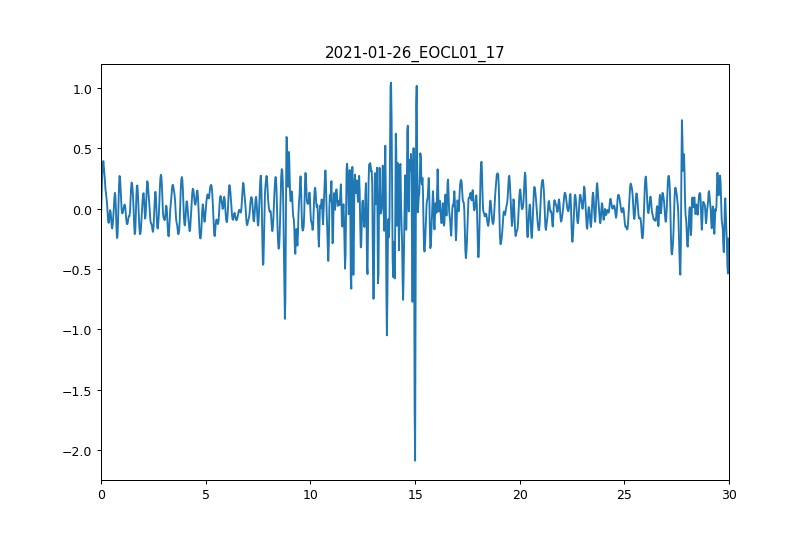

Text(0.5, 1.0, '2021-01-26_EOCL01_17')

In [23]:
%matplotlib notebook
# Generate a random integer between 0 and total number of signals at EOCL
rand_int = random.randint(0, EOCL_data.shape[0])
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting randomly indexed signal
fig = plt.figure(figsize=(9,6))
data_label, data_tmp = mcaap.extract_signals_from_dict(row_dict_EOCL, rand_int)
plt.plot(t_data, data_tmp)
plt.xlim([0,30]); plt.title(data_label)

---
Saving Each Database

In [24]:
%%time
data_dir = 'Databases/'
with open(data_dir+'MCA_dict.pkl', 'wb') as f:
    pickle.dump(row_dict_MCA, f) 
with open(data_dir+'EOCR_dict.pkl', 'wb') as f:
    pickle.dump(row_dict_EOCR, f) 
with open(data_dir+'EOCL_dict.pkl', 'wb') as f:
    pickle.dump(row_dict_EOCL, f) 

CPU times: user 31.6 ms, sys: 78.8 ms, total: 110 ms
Wall time: 478 ms


---
Miscellaneous code

In [ ]:
%%time
# Directory path to EOCR trimmed data
file_pattern = winter_data_dir+'EOCR_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
EOCR_data = []; row_labels_EOCR = []
for EOCR_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(EOCR_data_filepath)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter 5 - 10 Hz center cue
    st_center = st.copy() # 5 - 10 Hz center cue
    st_center.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_center.filter('bandpass', freqmin=freqmin, freqmax=freqmax)
    except:
        st_center = st_center.split()
        st_center.filter('bandpass', freqmin=freqmin, freqmax=freqmax)
        st_center.merge()
    # Filter 1 - 10 Hz store
    st_save = st.copy()
    st_save.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_save.filter('bandpass', freqmin=freqmin, freqmax=freqmax)
    except:
        st_save = st_save.split()
        st_save.filter('bandpass', freqmin=freqmin, freqmax=freqmax)
        st_save.merge()
    julian_day = EOCR_data_filepath[-8:-6] # as string
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load start and end times for all signals on this day
    df_tmp = pd.read_csv(winter_data_dir+'EOCR_Detections/Signal_Times/'+julian_day+'.csv')
    for tr_c in st_center:
        # match same station in st_save
        tr_s_list = st_save.select(station=tr_c.stats.station)
        if len(tr_s_list) == 0: 
            continue
        tr_s = tr_s_list[0]        
        # Construct time vector for data time window
        t = np.arange(0, tr_c.stats.delta*tr_c.stats.npts, tr_c.stats.delta)
        st_tmp = Stream().append(tr_c)
        for sig_idx in range(len(df_tmp)): # loop through each signal
            #-----------------------------------------------------------------------------------------------------------------------#
            # Fixing issues after manually checking signals
            if str(st[0].stats.starttime).split('T')[0] == '2021-01-13':
                if tr.stats.station == 'EOC03':
                    if sig_idx+1 == 2:
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-01-23':
                if tr.stats.station == 'EOC03':
                    continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-01-26':
                if (sig_idx+1 == 26) or (sig_idx+1==30) or (sig_idx+1==31):
                    continue
            #-----------------------------------------------------------------------------------------------------------------------#
            sig_time_tmp = (df_tmp['end_time'][sig_idx] + df_tmp['start_time'][sig_idx]) / 2 # use midpoint between Cardinal families' start and end times
            t_data, data = mcaap.data_time_window(t, st_tmp, t_start=sig_time_tmp-15, t_end=sig_time_tmp+15)
            # Desired length
            target_length = int(tr.stats.sampling_rate) * 30 # sampling rate and time window length
            if data.shape[1] != target_length:
                # Calculate padding required on each side
                pad_width = target_length - data.shape[1]
                # Pad the array on both sides to reach target length
                data = np.pad(data, (0, pad_width), mode='constant')
            EOCR_data.append(data[0,:])
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number
            row_labels_EOCR.append(str(tr.stats.starttime).split('T')[0] + '_'+tr.stats.station+'_'+str(sig_idx+1))
EOCR_data = np.array(EOCR_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_EOCR = {label: EOCR_data[idx] for idx, label in enumerate(row_labels_EOCR)}
print(EOCR_data.shape)

In [ ]:
%%time
# Directory path to EOCL trimmed data
file_pattern = winter_data_dir+'EOCL_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
EOCL_data = []; row_labels_EOCL = []
for EOCL_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(EOCL_data_filepath)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter
    st_filt = st.copy()
    st_filt.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_filt.filter('bandpass', freqmin=freqmin, freqmax=freqmax)
    except:
        st_filt = st_filt.split()
        st_filt.filter('bandpass', freqmin=freqmin, freqmax=freqmax)
        st_filt.merge()
    julian_day = EOCL_data_filepath[-8:-6] # as string
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load start and end times for all signals on this day
    df_tmp = pd.read_csv(winter_data_dir+'EOCL_Detections/Signal_Times/'+julian_day+'.csv')
    for tr in st_filt:
        # Construct time vector for data time window
        t = np.arange(0, tr.stats.delta*tr.stats.npts, tr.stats.delta)
        st_tmp = Stream().append(tr)
        for sig_idx in range(len(df_tmp)): # loop through each signal
            #-----------------------------------------------------------------------------------------------------------------------#
            # Fixing issues after manually checking signals
            if str(st[0].stats.starttime).split('T')[0] == '2021-01-23':
                if (sig_idx+1 == 5) or (sig_idx==24): continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-01-26':
                if sig_idx+1 == 7: continue
                if sig_idx+1 == 12: continue
                if sig_idx+1 == 15: continue
                if sig_idx+1 == 17: continue
                if sig_idx+1 == 18: continue
                if sig_idx+1 == 20: continue
                if sig_idx+1 == 24: continue
                if sig_idx+1 == 34: continue
                if sig_idx+1 == 35: continue
                if sig_idx+1 == 37: continue
                if sig_idx+1 == 41: continue
                if sig_idx+1 == 45: continue
                if sig_idx+1 == 48: continue
                if sig_idx+1 == 51: continue
                if sig_idx+1 == 53: continue
                if sig_idx+1 == 57: continue
                if sig_idx+1 == 60: continue
                if sig_idx+1 == 62: continue
                if sig_idx+1 == 67: continue
                if sig_idx+1 == 69: continue
                if sig_idx+1 == 75: continue
                if sig_idx+1 == 78: continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-02-01':
                if tr.stats.station + tr.stats.location == 'EOCL02':
                    if sig_idx+1 == 1:
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-02-02':
                if tr.stats.station + tr.stats.location == 'EOCL02':
                    if sig_idx+1 == 4:
                        continue                         
            #-----------------------------------------------------------------------------------------------------------------------#         
            if str(st[0].stats.starttime).split('T')[0] == '2021-02-05':
                if sig_idx+1 == 39: continue
            #-----------------------------------------------------------------------------------------------------------------------#       
            if str(st[0].stats.starttime).split('T')[0] == '2021-02-25':
                if sig_idx+1 == 7: continue
                if sig_idx+1 == 9: continue
                if sig_idx+1 == 22: continue
                if sig_idx+1 == 37: continue
                if sig_idx+1 == 54: continue              
            #-----------------------------------------------------------------------------------------------------------------------#       
            if str(st[0].stats.starttime).split('T')[0] == '2021-02-27':
                if sig_idx+1 == 4: continue
                if sig_idx+1 == 6: continue
                if sig_idx+1 == 10: continue
                if sig_idx+1 == 14: continue
                if sig_idx+1 == 16: continue 
                if sig_idx+1 == 24: continue
                if sig_idx+1 == 29: continue                
            sig_time_tmp = (df_tmp['end_time'][sig_idx] + df_tmp['start_time'][sig_idx]) / 2 # use midpoint between Cardinal families' start and end times
            t_data, data = mcaap.data_time_window(t, st_tmp, t_start=sig_time_tmp-15, t_end=sig_time_tmp+15)
            # Desired length
            target_length = int(tr.stats.sampling_rate) * 30 # sampling rate and time window length
            if data.shape[1] != target_length:
                # Calculate padding required on each side
                pad_width = target_length - data.shape[1]
                # Pad the array on both sides to reach target length
                data = np.pad(data, (0, pad_width), mode='constant')
            EOCL_data.append(data[0,:])
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number
            row_labels_EOCL.append(str(tr.stats.starttime).split('T')[0] + '_'+tr.stats.station+tr.stats.location+'_'+str(sig_idx+1))
EOCL_data = np.array(EOCL_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_EOCL = {label: EOCL_data[idx] for idx, label in enumerate(row_labels_EOCL)}
print(EOCL_data.shape)